In [6]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [7]:
BASE_DIR = os.getcwd()
print(f"📍 Directorio actual del Notebook: {BASE_DIR}")

📍 Directorio actual del Notebook: d:\Uni OViedo\Clases\Practicas\PROYECTO


In [8]:


# 2. Configurar rutas relativas

DATA_YAML_PATH = os.path.join(BASE_DIR,"dataset", "data.yaml")

# 3. Definir los modelos a comparar

MODELOS = [
    {
        "nombre": "Modelo V1 ", 
        "path": "modelos/yolo11n_train_v1.pt", # <--- Revisa este nombre
        "color": "#FF9999"
    },
    {
        "nombre": "Modelo V2 ", 
        "path": "modelos/yolo11s_train_v1.pt", 
        "color": "#66B3FF"
    },
     {
         "nombre": "Modelo V3", 
         "path": "modelos/yolo11s_train_v1.pt",
         "color": "#99FF99"
     }
]

# 4. Verificación de seguridad antes de empezar
print("\n🔍 Verificando archivos...")
if os.path.exists(DATA_YAML_PATH):
    print(f"✅ Dataset encontrado: {DATA_YAML_PATH}")
else:
    print(f"❌ ERROR: No encuentro el dataset en: {DATA_YAML_PATH}")

for m in MODELOS:
    full_path = os.path.join(BASE_DIR, m["path"])
    if os.path.exists(full_path):
        print(f"✅ Modelo encontrado: {m['nombre']}")
    else:
        print(f"❌ ERROR: No encuentro el modelo en: {full_path}")


🔍 Verificando archivos...
✅ Dataset encontrado: d:\Uni OViedo\Clases\Practicas\PROYECTO\dataset\data.yaml
✅ Modelo encontrado: Modelo V1 
✅ Modelo encontrado: Modelo V2 
✅ Modelo encontrado: Modelo V3


In [9]:
def evaluar_modelos_notebook():
    resultados = []
    print(f"🚀 Iniciando evaluación sobre el conjunto de TEST...\n")

    for config in MODELOS:
        nombre = config["nombre"]
        ruta_relativa = config["path"]
        ruta_absoluta = os.path.join(BASE_DIR, ruta_relativa)
        
        # Saltamos si el archivo no existe (para que no rompa el loop)
        if not os.path.exists(ruta_absoluta):
            continue

        print(f"🤖 Evaluando: {nombre}...")
        
        try:
            # Cargar modelo
            model = YOLO(ruta_absoluta)
            
            # Validar en TEST
            # plots=False agiliza el proceso
            metrics = model.val(data=DATA_YAML_PATH, split='test', verbose=False, plots=False)
            
            # Extraer métricas
            info = {
                "Modelo": nombre,
                "mAP@50-95": round(metrics.box.map, 4),       # Precisión Estricta
                "mAP@50": round(metrics.box.map50, 4),        # Detección General
                "Precision": round(metrics.box.mp, 4),
                "Recall": round(metrics.box.mr, 4),
                "Inferencia (ms)": round(metrics.speed['inference'], 2),
                "Params (M)": round(model.info()[1] / 1e6, 2) # Millones de parámetros
            }
            resultados.append(info)
            
        except Exception as e:
            print(f"❌ Error evaluando {nombre}: {e}")

    return pd.DataFrame(resultados)

🚀 Iniciando evaluación sobre el conjunto de TEST...

🤖 Evaluando: Modelo V1 ...
Ultralytics 8.3.217  Python-3.10.2 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 960M, 2048MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 2.20.9 MB/s, size: 39.7 KB)
val: Scanning D:\Uni OViedo\Clases\Practicas\PROYECTO\dataset\test\labels.cache... 390 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 390/390 392.2Kit/s 0.0s
WARNING NMS time limit 2.050s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 0.4it/s 57.8s0.4s
                   all        390        888      0.875       0.84      0.901      0.569
Speed: 5.0ms preprocess, 26.0ms inference, 0.0ms loss, 2.7ms postprocess per image
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
🤖 Evaluando: Modelo V2 ...
Ultralytics 8.3.217  Python-3.10.2 torch-2.7.0+cu1

### 📊 Tabla de Resultados Comparativa

,Modelo,mAP@50-95,mAP@50,Precision,Recall,Inferencia (ms),Params (M)
1,Modelo V2,0.5764,0.8989,0.8846,0.8512,42.17,9.41
2,Modelo V3,0.5764,0.8989,0.8846,0.8512,41.37,9.41
0,Modelo V1,0.5692,0.9015,0.8752,0.8403,25.97,2.58



📈 Generando gráficas visuales...


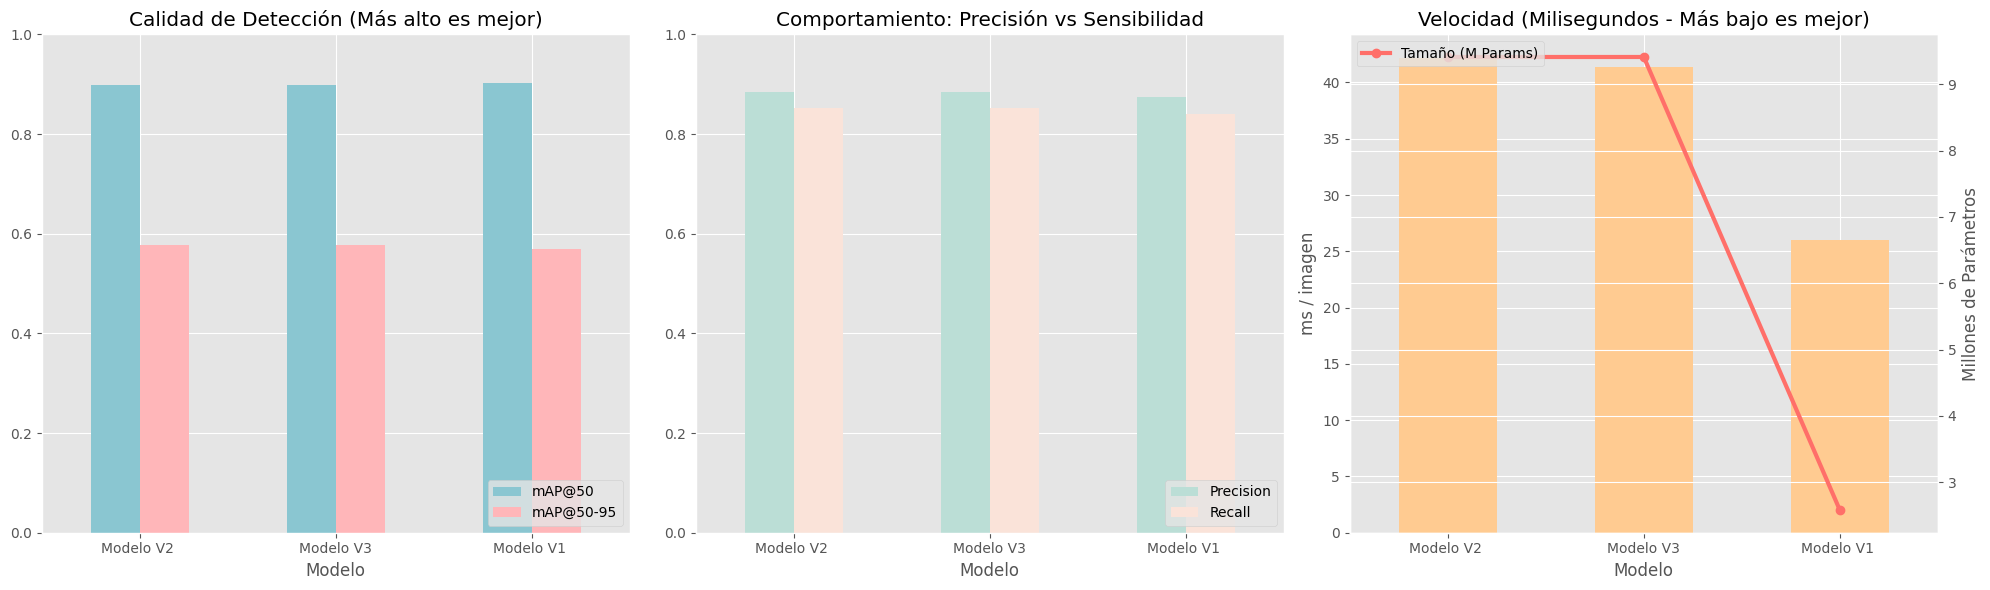

🏆 GANADOR TÉCNICO: Modelo V2  con un mAP50-95 de 0.5764


In [10]:
df_resultados = evaluar_modelos_notebook()

# 2. Mostrar Resultados
if not df_resultados.empty:
    display(Markdown("### 📊 Tabla de Resultados Comparativa"))
    # Ordenamos por la métrica más importante (mAP50-95)
    df_sorted = df_resultados.sort_values(by="mAP@50-95", ascending=False)
    display(df_sorted)
    
    # 3. Generar Gráficas
    print("\n📈 Generando gráficas visuales...")
    plt.style.use('ggplot') # Estilo bonito
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Gráfica A: Calidad (mAP)
    df_sorted.plot(x="Modelo", y=["mAP@50", "mAP@50-95"], kind="bar", ax=axes[0], 
            color=['#8ac6d1', '#ffb6b9'], rot=0)
    axes[0].set_title("Calidad de Detección (Más alto es mejor)")
    axes[0].set_ylim(0, 1.0)
    axes[0].legend(loc='lower right')

    # Gráfica B: Precision vs Recall
    df_sorted.plot(x="Modelo", y=["Precision", "Recall"], kind="bar", ax=axes[1], 
            color=['#bbded6', '#fae3d9'], rot=0)
    axes[1].set_title("Comportamiento: Precisión vs Sensibilidad")
    axes[1].set_ylim(0, 1.0)
    axes[1].legend(loc='lower right')

    # Gráfica C: Velocidad
    ax3 = axes[2]
    df_sorted.plot(x="Modelo", y="Inferencia (ms)", kind="bar", ax=ax3, 
                   color='#ffcb91', rot=0, legend=False)
    ax3.set_title("Velocidad (Milisegundos - Más bajo es mejor)")
    ax3.set_ylabel("ms / imagen")
    
    # Añadir línea de parámetros (Eje derecho)
    ax3_twin = ax3.twinx()
    ax3_twin.plot(df_sorted["Modelo"], df_sorted["Params (M)"], color='#ff6f69', marker='o', linewidth=3, label="Tamaño (M Params)")
    ax3_twin.set_ylabel("Millones de Parámetros")
    ax3_twin.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    
    # 4. Conclusión Automática
    mejor_modelo = df_sorted.iloc[0]
    print(f"🏆 GANADOR TÉCNICO: {mejor_modelo['Modelo']} con un mAP50-95 de {mejor_modelo['mAP@50-95']}")

else:
    print("⚠️ No se obtuvieron datos. Revisa las rutas en la Celda 2.")